#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.  
Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.        

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders`.

## Подготовка

In [1]:
!pip install scikit-learn==1.4

In [2]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from lightgbm import LGBMRegressor

In [3]:
# data = pd.read_csv("/datasets/taxi.csv", parse_dates=['datetime'])
data = pd.read_csv("C://Users//smirn//Downloads//Практикум//датасеты//taxi.csv", parse_dates=['datetime'])
data = data.set_index('datetime')
data.index.is_monotonic

True

In [4]:
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


Сделал `datatime` новым индексом.

## Анализ

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [7]:
data.isna().sum()

num_orders    0
dtype: int64

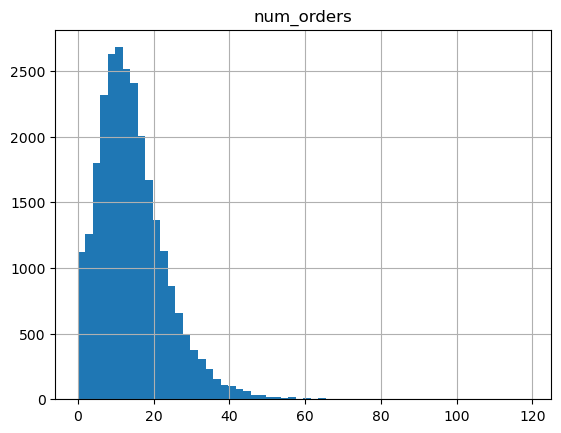

In [8]:
data.hist(bins=60);

In [9]:
data = data.resample('1H').sum()

Сделал ресэмплирование, взял новый интервал в один час.

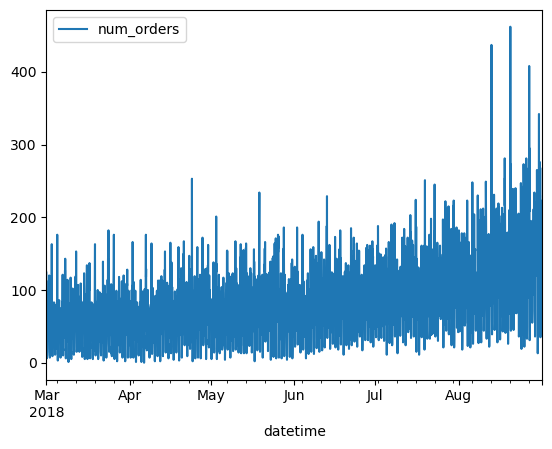

In [10]:
data.plot();

Построил график временного ряда.

Выделил сезонность, тренд и остаток:

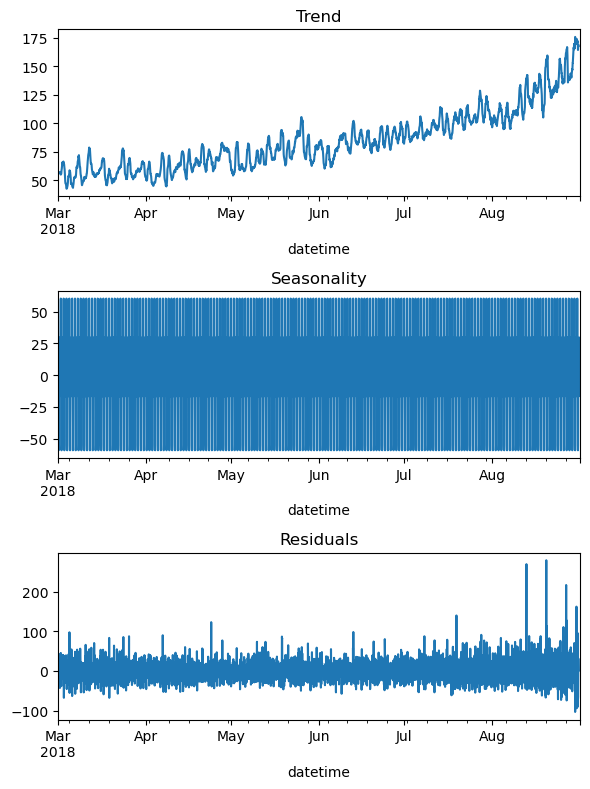

In [11]:
decomposed = seasonal_decompose(data)
plt.figure(figsize=(6,8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Видно восходящий тренд у временного ряда. Следовательно, можно сделать вывод, что ряд нестационарный.

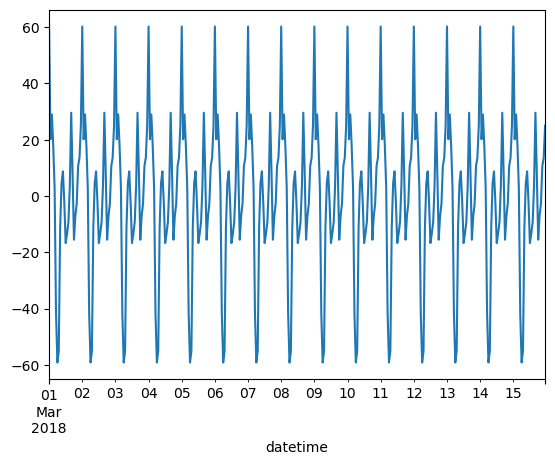

In [12]:
seasonality = decomposed.seasonal
seasonality['2018-03-01':'2018-03-15'].plot();

Период сезонности - один день.

In [13]:
data['rolling_mean'] = data.rolling(100).mean()

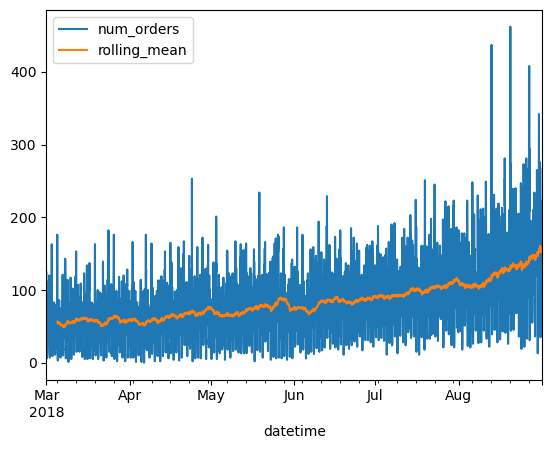

In [14]:
data.plot();

In [15]:
data['std'] = data['num_orders'].rolling(100).std()

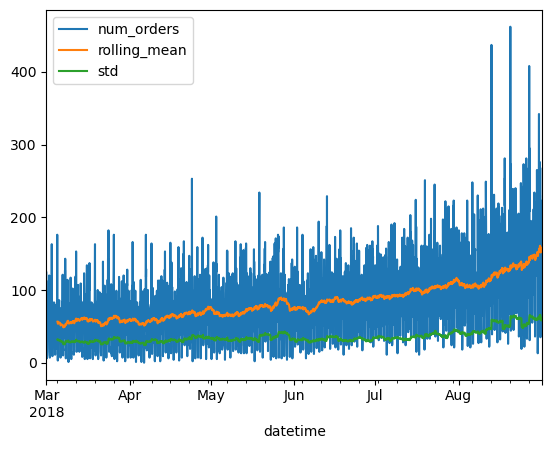

In [16]:
data.plot();

По графику видно, что дисперсия в конце растёт. Следовательно, ещё один аргумент в пользу нестационарности ряда.

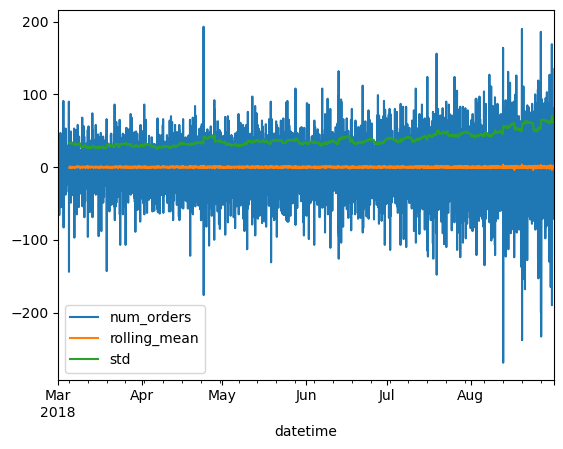

In [17]:
df = data.copy()
df['num_orders'] = df['num_orders'] - df['num_orders'].shift()
df['rolling_mean'] = df['num_orders'].rolling(100).mean()
df['std'] = df['num_orders'].rolling(100).std()
df.plot();

При дифференцировании убивается тренд. Поэтому на графике скользящее среднее примерно ноль.

## Обучение

In [18]:
def make_features(data, max_lag, rolling_mean_size):
    data_new = data.copy()    
    data_new['month'] = data.index.month
    data_new['day'] = data.index.day
    data_new['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data_new['lag_' + str(lag)] = data['num_orders'].shift(lag)
    
    data_new['rolling_mean'] = data_new['num_orders'].shift(1).rolling(rolling_mean_size).mean()
    
    return data_new

In [19]:
data_new = make_features(data, 24, 24)

Добавил признаки в таблицу.

In [20]:
data_new = data_new.drop('std', axis=1)

In [21]:
data_new.head(25)

,num_orders,rolling_mean,month,day,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,3,1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,3,1,1,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,3,1,2,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,3,1,4,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,NaN,3,1,5,43.0,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,NaN,3,1,6,6.0,43.0,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,NaN,3,1,7,12.0,6.0,43.0,66.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,NaN,3,1,8,15.0,12.0,6.0,43.0,66.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
RANDOM_STATE=42

train, test = train_test_split(data_new, shuffle=False, test_size=0.1, random_state=RANDOM_STATE)

train = train.dropna()

X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']

X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3950, 28)
(3950,)
(442, 28)
(442,)


Разделил данные на `train` и `test`. После на признаки и целевой признак.

### Линейная регрессия

In [23]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print('RMSE обучающей выборки:', root_mean_squared_error(y_train, lr.predict(X_train)))

RMSE обучающей выборки: 25.706933654818965


### Линейная регрессия с StandardScaler

In [24]:
X_train_df = X_train.copy()
y_train_df = y_train.copy()

scaler = StandardScaler()

X_train_df_scaled = scaler.fit_transform(X_train_df)

lr_ss = LinearRegression().fit(X_train_df_scaled, y_train_df)

print('RMSE обучающей выборки:', root_mean_squared_error(y_train_df, lr_ss.predict(X_train_df_scaled)))

RMSE обучающей выборки: 25.706933654818965


### Решающее дерево

In [25]:
tree = DecisionTreeRegressor(random_state=RANDOM_STATE)

parameters = {'min_samples_split': range(2,6),
              'max_depth': range(2,8),
              'min_samples_leaf': range(1,5)}

tscv = TimeSeriesSplit(n_splits=5)

gs = GridSearchCV(tree,
                  parameters,
                  n_jobs=-1,
                  cv=tscv,
                  scoring='neg_root_mean_squared_error')

gs.fit(X_train, y_train)

print('Гиперпараметры', gs.best_params_)
print('RMSE', gs.best_score_)

Гиперпараметры {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
RMSE -29.44638198493187


In [26]:
final_tree = DecisionTreeRegressor(min_samples_split=gs.best_params_['min_samples_split'],
                                   max_depth=gs.best_params_['max_depth'],
                                   min_samples_leaf=gs.best_params_['min_samples_leaf'],
                                   random_state=RANDOM_STATE)
final_tree.fit(X_train, y_train)

print('RMSE обучающей выборки:', root_mean_squared_error(y_train, final_tree.predict(X_train)))

RMSE обучающей выборки: 24.981555308254777


### Случайный лес

In [27]:
%%time
forest_model = RandomForestRegressor(random_state=RANDOM_STATE)

parameters = {'n_estimators': range(1,101,25),
              'min_samples_split': range(2,6),
              'max_depth': range(2,8),
              'min_samples_leaf': range(1,5)}

gs = GridSearchCV(forest_model,
                  parameters,
                  n_jobs=-1,
                  cv=tscv,
                  scoring='neg_root_mean_squared_error')

gs.fit(X_train, y_train)

print('Гиперпараметры', gs.best_params_)
print('RMSE', gs.best_score_)

Гиперпараметры {'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 76}
RMSE -26.135509070275635
Wall time: 2min 2s


In [28]:
final_forest_model = RandomForestRegressor(min_samples_split=gs.best_params_['min_samples_split'],
                                           max_depth=gs.best_params_['max_depth'],
                                           min_samples_leaf=gs.best_params_['min_samples_leaf'],
                                           n_estimators=gs.best_params_['n_estimators'],
                                           random_state=RANDOM_STATE)
final_forest_model.fit(X_train, y_train)

print('RMSE обучающей выборки:', root_mean_squared_error(y_train, final_forest_model.predict(X_train)))

RMSE обучающей выборки: 19.779164827443736


Лучше всего себя показал случайный лес.

## Тестирование

In [29]:
print('RMSE тестовой выборки:', root_mean_squared_error(y_test, final_forest_model.predict(X_test)))

RMSE тестовой выборки: 45.316687129268516


На тесте получили с помощью `RandomForestRegressor` RMSE меньше 48.

In [30]:
df = pd.DataFrame(index=y_test.index)
df['y_test'] = y_test.values
df['predict'] = final_forest_model.predict(X_test)
df

,y_test,predict
datetime,,
2018-08-13 14:00:00,102,108.650855
2018-08-13 15:00:00,175,123.141275
2018-08-13 16:00:00,144,138.186507
2018-08-13 17:00:00,152,123.493663
2018-08-13 18:00:00,104,105.568618
...,...,...
2018-08-31 19:00:00,136,127.755628
2018-08-31 20:00:00,154,147.772762
2018-08-31 21:00:00,159,138.296445


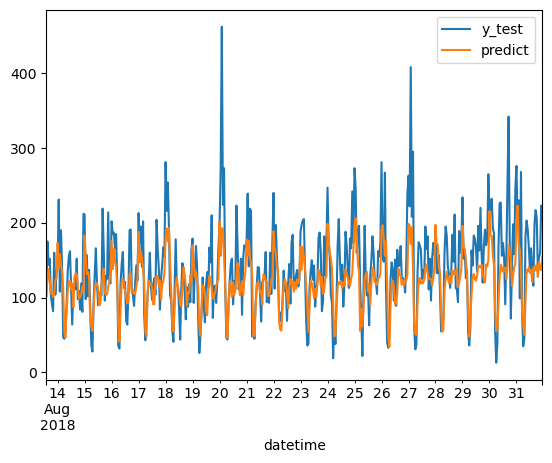

In [31]:
df.plot();

По графику видим, что данные несколько отличаются, но достаточно похожи

## Вывод

Имея исторические данные о заказах такси в аэропортах, необходимо спрогнозировать количество заказов такси на следующий час. 

Провели ресемплирование данных с горизонтом прогнозирования в один час.     

Изучив графики, заметили восходящий тренд и растущую дисперсию. Из чего сделали вывод о нестационарности временного ряда.    

Добавили новые признаки в таблицу: час, день, месяц, лаги и скользящее среднее.     

На тренировочных данных обучили разные модели с перебором гиперпараметров. В результате выбрали `RandomForestRegressor` и получили на тестовых данных RMSE 45.316687.    